# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [9]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [10]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/UGC04416/aUGC04416_I.fits')
data = hdu['PRIMARY'].data

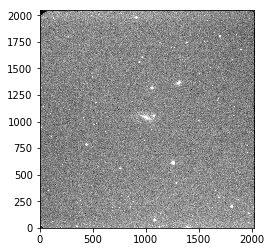

In [11]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=23, vmax=31)

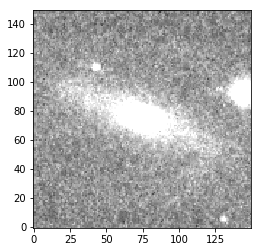

In [12]:
#cut
from astropy.nddata import Cutout2D
position = (1002, 1037)
size=(150,150)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=23, vmax=31)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [13]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

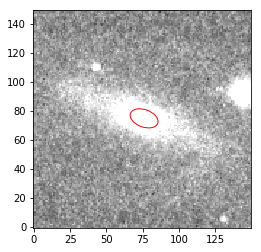

In [23]:
# how does it look?
geometry = EllipseGeometry (x0=76, y0=75, sma=10, eps=0.6,pa=160*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=23, vmax=31)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [24]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [25]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,66.29186717437473,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5209868481924366,63.36233328516244,0.09707933204561295,0.2668974270099277,0.020911243709226337,174.116010486,2.767186495,0.40214374769393196,13,0,10,0
0.5730855330116803,63.007854793009464,0.10707562274982807,0.26833548414807395,0.02100166826050471,173.763184271,2.7657818748,0.4043987750947718,13,0,10,0
0.6303940863128483,62.623258524309115,0.11808414203166627,0.2708951574993904,0.021034406188907347,173.381116919,2.74748657547,0.4056808264765023,13,0,10,0
0.6934334949441332,62.200873481589625,0.12976419964147462,0.2733007082625946,0.020844981814828578,172.950345946,2.70155411858,0.4006317816083688,13,0,10,0
0.7627768444385465,61.72839278581058,0.1411237168011395,0.27404299277341343,0.020631025700277944,172.473341617,2.66956549727,0.39717944211658607,13,0,10,0
0.8390545288824012,61.20736672005062,0.1533875827609217,0.27440366532553456,0.018010319615830134,172.008823251,2.32695461555,0.3384207898220936,13,0,10,0
0.9229599817706413,60.226467658093334,0.1746641489677253,0.21128362476232182,0.018379339321174658,169.001561342,2.97531270139,0.31582939963062545,13,0,10,0


Text(0,0.5,'Ellipticity')

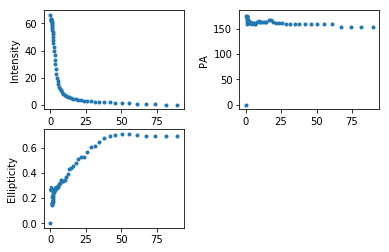

In [26]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [27]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

KeyboardInterrupt: 

In [ ]:
norm_model = simple_norm(model_image,stretch='asinh',percent=99.9)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98.5)
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', norm=norm_data)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')